# Expressions, @system macro

- https://gist.github.com/mforets/8be4d0b1fc91800bcbd78f73dd87b379
- https://gist.github.com/MikeInnes/8299575
- http://mikeinnes.github.io/MacroTools.jl/stable/pattern-matching/

In [3]:
using TreeView

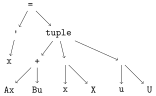

In [4]:
@tree x' = Ax + Bu, x ∈ X, u ∈ U

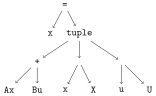

In [5]:
@tree x⁺ = Ax + Bu, x ∈ X, u ∈ U

In [ ]:

S = :(x' = Ax + Bu, x ∈ X, u ∈ U)

using MacroTools
using MacroTools: postwalk

expr = :(x' = Ax + Bu, x ∈ X, u ∈ U)
postwalk(Expr(expr))

postwalk(x -> x == :Ax ? :AA : x, :(x' = Ax + b + 1))

# Update in Reachability.jl

```julia
$ git diff
diff --git a/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl b/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl
index 82e4bed..65c70c0 100644
--- a/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl
+++ b/src/ReachSets/ContinuousPost/BFFPSV18/reach.jl
@@ -85,9 +85,7 @@ function reach(problem::Union{IVP{<:CLDS{NUM}, <:LazySet{NUM}},

     # shortcut if only the initial set is required
     if N == 1
-        res[1] = res_type(
-            CartesianProductArray{NUM, LazySet{NUM}}(Xhat0[blocks]),
-            zero(NUM), options[:δ])
+        res[1] = SparseReachSet(CartesianProductArray(Xhat0[blocks]), zero(NUM), options[:δ], dimensions)
         return res
     end
     push!(args, Xhat0)
diff --git a/src/ReachSets/ReachSolution.jl b/src/ReachSets/ReachSolution.jl
index 39bd609..4f10ef4 100644
--- a/src/ReachSets/ReachSolution.jl
+++ b/src/ReachSets/ReachSolution.jl
@@ -15,8 +15,7 @@ struct ReachSolution{SN, RSN<:AbstractReachSet{SN}} <: AbstractSolution
 end

 # constructor with no options
-ReachSolution(Xk::Vector{RSN}) where {SN, RSN<:AbstractReachSet{SN}} =
-    ReachSolution{SN, RSN}(Xk, Options())
+ReachSolution(Xk::Vector{RSN}) where {SN, RSN<:AbstractReachSet{SN}} = ReachSolution{SN, RSN}(Xk, Options())

 function project(rs::ReachSolution, M::AbstractMatrix)
     Yk = [project(X, M) for X in rs.Xk]
```

# Plots for unbounded sets (#1910)

In [1]:
using Revise, LazySets, Plots

In [2]:
H = rand(Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([1.0709542180886178, -0.2150366400810182], [0.1541316890259692, 0.1235821360346745])

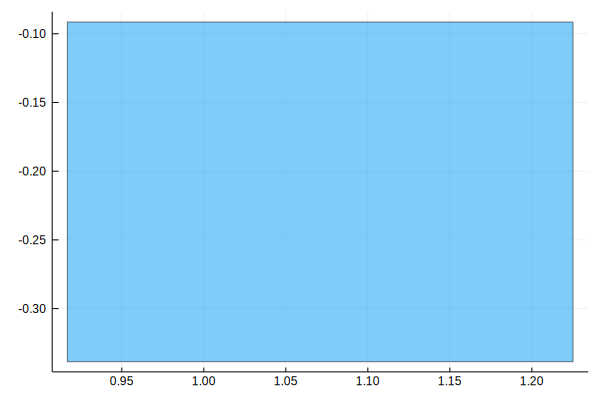

In [3]:
plot(H)

In [10]:
X = HalfSpace([1.0, 0.0], 2.0)
Y = HalfSpace([1.0, 2.0], -1.0)

HalfSpace{Float64,Array{Float64,1}}([1.0, 2.0], -1.0)

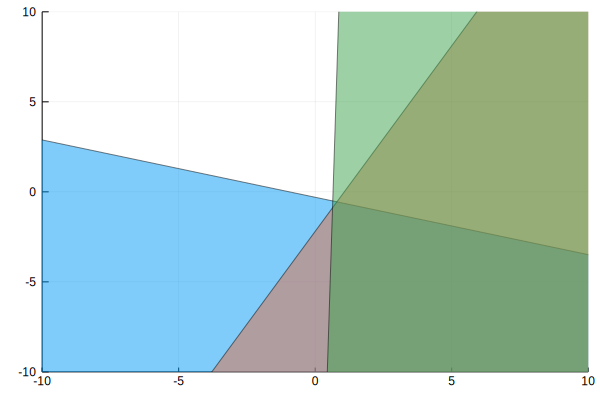

In [35]:
H1 = rand(HalfSpace)
H2 = rand(HalfSpace)
H3 = rand(HalfSpace)
plot(H1, xlims=(-10, 10), ylims=(-10, 10))
plot!(H2)
plot!(H3)

In [37]:
@which isbounded(Z)

isbounded(::AbstractPolytope) in LazySets at /home/mforets/.julia/dev/LazySets/src/Interfaces/AbstractPolytope.jl:56

# Matrix powers of interval matrices

Our running example is taken from the transmission line model.

In [14]:
using MathematicalSystems, LinearAlgebra, SparseArrays, IntervalMatrices
import IntervalArithmetic; const IA = IntervalArithmetic

function tline(;η=2, R=1.00, Rd=10.0, L=1e-10, C=1e-13 * 4.00, scale=1e-9)
    A₁₁ = zeros(η, η)
    A₁₂ = Bidiagonal(fill(-1/C, η), fill(1/C, η-1), :U)
    A₂₁ = Bidiagonal(fill(1/L, η), fill(-1/L, η-1), :L)
    A₂₂ = Diagonal(vcat(-Rd/L, fill(-R/L, η-1)))
    A  = [A₁₁ A₁₂; A₂₁ A₂₂]
    B = sparse([η+1], [1], 1/L, 2η, 1)
    return A * scale, B * scale
end

tline (generic function with 1 method)

In [20]:
# scalar parameters
A, B = tline();
δ = 0.002
eAδ = exp(Matrix(A) * δ)

4×4 Array{Float64,2}:
  0.905497   0.0484535    -4.37927     4.70961  
  0.0484535  0.951152     -0.0777469  -4.78736  
  0.0175171  0.000310987   0.77567     0.0453436
 -0.0188385  0.0191494     0.0453436   0.883549 

In [43]:
# interval parameters
using IntervalMatrices
using IntervalMatrices: expm_overapproximation, quadratic_expansion

R = IA.Interval(0.99, 1.01)
Rdriver = IA.Interval(9.9, 10.1)
L = IA.Interval(1e-10, 1e-10)
C = IA.Interval(3.99e-13, 4.01e-13)

A, B = tline(R=R, Rd=Rdriver, L=L, C=C);
A = IntervalMatrix(A)
δ = 0.002
A

4×4 IntervalMatrix{Float64,Interval{Float64},SparseMatrixCSC{Interval{Float64},Int64}}:
 [0, 0]                  [0, 0]                  …   [2493.76, 2506.27]   
 [0, 0]                  [0, 0]                     [-2506.27, -2493.76]  
     [9.99999, 10.0001]  [0, 0]                     [0, 0]                
   [-10.0001, -9.99999]      [9.99999, 10.0001]       [-10.1001, -9.89999]

In [44]:
eAδ = expm_overapproximation(A, 0.002, 10)

4×4 IntervalMatrix{Float64,Interval{Float64},Array{Interval{Float64},2}}:
  [0.905184, 0.905808]     …   [4.69538, 4.7239]    
  [0.0483178, 0.0485898]      [-4.80115, -4.77363]  
  [0.0174919, 0.0175423]       [0.045162, 0.0455256]
 [-0.0188434, -0.0188335]      [0.883074, 0.884023] 

In [45]:
ϕ = copy(eAδ)

4×4 IntervalMatrix{Float64,Interval{Float64},Array{Interval{Float64},2}}:
  [0.905184, 0.905808]     …   [4.69538, 4.7239]    
  [0.0483178, 0.0485898]      [-4.80115, -4.77363]  
  [0.0174919, 0.0175423]       [0.045162, 0.0455256]
 [-0.0188434, -0.0188335]      [0.883074, 0.884023] 

In [51]:
# compute ϕ, ϕ^2, ..., ϕ^k assuming k >= 2
function f(ϕ, k)
    ϕpowers = [ϕ]
    for i in 2:k
        push!(ϕpowers,  ϕpowers[i-1] * ϕ)
    end
    return ϕpowers
end

f (generic function with 1 method)

In [47]:
p = f(ϕ, 10);

In [54]:
ϕ² = quadratic_expansion(ϕ, sqrt(2)) - ϕ * sqrt(2)

4×4 Array{Interval{Float64},2}:
  [0.654659, 0.659014]     [0.177826, 0.179747]     …   [7.92275, 8.06769]  
  [0.177834, 0.179739]     [0.814409, 0.816264]        [-8.62719, -8.49032] 
  [0.0284552, 0.0287649]   [0.0022412, 0.00226701]      [0.154948, 0.157545]
 [-0.0320254, -0.0319359]  [0.0342024, 0.0342672]       [0.599546, 0.605084]

In [57]:
p[2]

4×4 IntervalMatrix{Float64,Interval{Float64},Array{Interval{Float64},2}}:
  [0.65554, 0.658133]      [0.178211, 0.179363]      …   [7.96308, 8.02737]  
  [0.178219, 0.179355]     [0.814787, 0.815886]         [-8.58827, -8.52923] 
  [0.0285263, 0.0286938]   [0.00224433, 0.00226389]      [0.155462, 0.157031]
 [-0.0320115, -0.0319499]  [0.0342132, 0.0342564]        [0.600887, 0.603744]

In [62]:
ϕ² .⊆ p[2]

4×4 BitArray{2}:
 0  0  0  0
 0  0  0  0
 0  0  0  0
 0  0  0  0

In [41]:
# compute ϕ, ϕ^2, ϕ^4, ϕ^6, ..., ϕ^k assuming k >= 2 and even
# and using quadratic_expansion
function feven(ϕ, k)
    ϕpowers = [ϕ]
    #=
    c = 2
    for i in 2:2:k
        push!(ϕpowers,  ϕpowers[c-1] * ϕ)
        c += 1
    end
    return ϕpowers
    =#
end

4×4 IntervalMatrix{Float64,Interval{Float64},Array{Interval{Float64},2}}:
  [0.236017, 0.341538]      …  [-11.6155, -9.87505]    
 [-0.0459135, 0.0361175]         [1.92774, 3.26819]    
 [-0.00106913, 0.00409612]      [-0.372584, -0.289022] 
  [0.0404059, 0.0455482]        [-0.0369267, 0.0486635]